In [ ]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings("ignore", message="Parsing dates in .* when dayfirst=True was specified")
warnings.filterwarnings("ignore", category=FutureWarning)

from preprocessing import *
import tame
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from config import CONFIG

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, Subset, random_split, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _cuda(obj):
    if isinstance(obj, torch.nn.Module):
        return obj.cuda()
    elif isinstance(obj, torch.Tensor):
        return obj.cuda()
    elif isinstance(obj, np.ndarray):
        return torch.from_numpy(obj).cuda()
    
def index_value(data):
    index = data // (CONFIG['split_num'] + 1)
    value = data % (CONFIG['split_num'] + 1)
    index = Variable(_cuda(index))
    value = Variable(_cuda(value))
    return [index, value]


In [2]:
dfs = get_dfs()
biopsy_df = dfs['biopsy'].copy()
static_df = create_static_df(dfs)
vital_df = create_vitals_df(dfs, static_df)
med_df = create_medication_df(dfs, static_df)
lab_df = create_lab_values_df(dfs, static_df)
ts_data = create_ts_df(vital_df, lab_df, med_df, merge_lab=True, merge_med=True)
print(ts_data.columns)

max rel_days 8034
max number of rows across all patients 1105
count    82236.000000
mean        35.956789
std          0.527301
min         34.000000
25%         35.700000
50%         36.000000
75%         36.200000
max         42.000000
Name: temperature, dtype: float64
count    79213.000000
mean        23.592491
std          2.153356
min          2.000000
25%         24.000000
50%         24.000000
75%         24.000000
max         24.000000
Name: diuresis_time, dtype: float64
Index(['patient_id', 'transplant_id', 'rel_days', 'bp_sys', 'bp_dia', 'weight',
       'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin',
       'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01',
       'L04AD02'],
      dtype='object')


In [3]:
full_dataset = NephroDataset(static_df, ts_data, biopsy_df, phase='test')
categorical_card = full_dataset.categorical_cardinalities
#balanced_dataset = get_balanced_subset(full_dataset, samples_per_class=50)
#datapoint_limit = 1000
#dataset = Subset(full_dataset, range(datapoint_limit))
train_size = int(0.7 * len(full_dataset))
#t_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = CONFIG['batch_size']
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Full dataset size: {len(full_dataset)}")

Train dataset size: 2172
Test dataset size: 931
Full dataset size: 3103


In [ ]:
checkpoint = torch.load('../model_checkpoints/models/best.ckpt', weights_only=False)
print(checkpoint.keys())
print(checkpoint['state_dict'].keys())

model = tame.AutoEncoder(categorical_cardinalities=categorical_card)
model.load_state_dict(checkpoint['state_dict'])

dict_keys(['epoch', 'best_metric', 'state_dict', 'best r2s'])
odict_keys(['embedding.weight', 'value_embedding.weight', 'static_encoder.embeddings.0.weight', 'static_encoder.embeddings.1.weight', 'static_encoder.embeddings.2.weight', 'static_encoder.embeddings.3.weight', 'static_encoder.embeddings.4.weight', 'static_encoder.embeddings.5.weight', 'static_encoder.embeddings.6.weight', 'static_encoder.embeddings.7.weight', 'static_encoder.numerical_processor.0.weight', 'static_encoder.numerical_processor.0.bias', 'static_encoder.fc.weight', 'static_encoder.fc.bias', 'value_mapping.0.weight', 'value_mapping.0.bias', 'mapping.0.weight', 'mapping.0.bias', 'mapping.2.weight', 'mapping.2.bias', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l1_reverse', 'ls

<All keys matched successfully>

In [ ]:
# load feature_mm file
with open('../feature_mm.json', 'r') as f:
    feature_mm = json.load(f)

print(list(feature_mm.keys()))

# load feature_ms file
with open('../feature_ms.json', 'r') as f:
    feature_ms = json.load(f)
print(list(feature_ms.keys()))
keys = list(feature_mm.keys())

means = torch.tensor([feature_ms[keys[i]][0] for i in range(15)], device=device)
stds = torch.tensor([feature_ms[keys[i]][1] for i in range(15)], device=device)

['bp_sys', 'bp_dia', 'weight', 'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin', 'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01', 'L04AD02']
['bp_sys', 'bp_dia', 'weight', 'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin', 'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01', 'L04AD02']


In [ ]:
def extract_horizon_reps(model, data_loader, horizons, target, label_rel_days):
    patient_sample_counts = {H: {} for H in horizons}

    # For each horizon, prepare storage for hidden reps, labels, day-of-step, patient_id
    hr_repr = {H: [] for H in horizons}
    hr_label = {H: [] for H in horizons}
    hr_days  = {H: [] for H in horizons}
    hr_pids  = {H: [] for H in horizons}
    hr_loss_days = {H: [] for H in horizons}

    model.eval()
    with torch.no_grad():
        
        for batch in tqdm(data_loader):
            pid = batch['patient_id']

            # Data with real values with rel_days(time)
            real_data = Variable(_cuda(batch['real_ts_data']))

            # Time series features
            ts_data = index_value(batch['input_ts_features'])
            #print(batch['input_ts_features'].shape) # (B, T, F) T==200
            neib = [index_value(batch['pre_input']), Variable(_cuda(batch['pre_time'])), index_value(batch['post_input']), Variable(_cuda(batch['post_time']))]

            # Static features
            static_num = Variable(_cuda(batch['static_numerical_features']))
            num = batch['static_numerical_features']
            static_cat = Variable(_cuda(batch['static_categorical_features']))
            cat = batch['static_categorical_features']

            pad_mask = Variable(_cuda(batch['mask']))
            lstm_out = model(ts_data, neib, static_num, static_cat, mask=pad_mask, get_embedding=False) # (B, T, 2* embedding_dim)
            #print(f"lstm_out shape: {lstm_out.shape}")  # (B, T, 2*embedding_dim)

            # Fill nans in real data with lstm_out
            # Fill NaNs in real_data with values from lstm_out for all features
            feature_data = real_data[:, :, 1:] 
            #nan_mask = torch.isnan(feature_data)
            #feature_data[nan_mask] = lstm_out[nan_mask]
            # fill nan with mean of the feature
            feature_data = feature_data.cpu().numpy()
            B, T, F = feature_data.shape
            for f in range(F):
                feat_values = feature_data[:, :, f]
                mean_val = np.nanmean(feat_values)  # mean of this feature ignoring NaNs
                nan_mask = np.isnan(feat_values)
                feature_data[:, :, f][nan_mask] = mean_val
            feature_data = torch.tensor(feature_data, device=device, dtype=torch.float32)

            real_features = (feature_data - means) / stds


            # Convert labels to list
            label = batch[target]
            labels_data = []
            for lb in label:
                if isinstance(lb, torch.Tensor):
                    if lb.numel() == 1:
                        lb = float(lb.item())
                    else:
                        lb = lb.cpu().numpy()
                labels_data.append(lb)

            # Convert rel_days to numpy array
            if label_rel_days is not None and label_rel_days in batch:
                raw_rel_days_data = batch[label_rel_days]
                rel_days_data = []
                for d in raw_rel_days_data:
                    if isinstance(d, torch.Tensor):
                        if d.numel() == 1:
                            d = float(d.item())
                        else:
                            d = d.cpu().numpy()
                    rel_days_data.append(d)
                rel_days_data = np.array(rel_days_data)
            else: 
                rel_days_data = None

            seq_lens = batch['seq_len']
            for i in range(lstm_out.shape[0]):
                patient_id_i = pid[i]

                label_i = labels_data[i] # this can be single label or list of event days
                seq_len = seq_lens[i].item()
                seq_len = min(seq_len, real_data.shape[1])

                if seq_len < 2:
                    continue

                tm_i = real_data[i, :seq_len, 0].cpu().numpy().flatten() #time steps

                for k in range(1, seq_len):
                    curr_day = tm_i[k]
                    #norm_curr_day = norm_tm_i[k]
                    
                    if curr_day < 30: # Get the embedddings for day 30 and more
                        continue

                    # Get the representation for this time step concatneate with its num , cat features

                    # Get the representation for this time step
                    rep_ts = real_features[i, 0:k+1, :].mean(dim=0).cpu().numpy() # mean over timesteps 0 to k inclusive

                    # Get static numerical and categorical features for this patient
                    rep_num = num[i].cpu().numpy() if isinstance(num, torch.Tensor) else np.array(num[i])
                    rep_cat = cat[i].cpu().numpy() if isinstance(cat, torch.Tensor) else np.array(cat[i])

                    # Concatenate all together: [time_step_representation | static_numerical | static_categorical]
                    rep = np.concatenate([rep_ts, rep_num, rep_cat])  # Final rep: (F_total,)

                    for H in horizons:
                        if patient_id_i not in patient_sample_counts[H]:
                            patient_sample_counts[H][patient_id_i] = 0

                        if rel_days_data is not None:
                            event_label = label_i # 0 or 1 
                            rel_day = rel_days_data[i]
                            hr_loss_days[H].append(rel_day)
                            if (event_label == 1) and (curr_day > rel_day):
                                #print(f"Skipping embedding for patient {patient_id_i}, curr_day {curr_day}, rel_day {rel_day}")
                               continue

                            elif (event_label == 1) and (0 <= (rel_day - curr_day) <= H):
                                label_ = 1
                            else:
                                label_ = 0

                        else:
                            # label_or_list is a list of event days or None
                            if isinstance(label_i, (list, np.ndarray)) and len(label_i) > 0:
                                # label_ = 1 if any day d in label_or_list satisfies (0 < d - cur_day <= H)
                                label_i = [float(d) for d in label_i if d is not None and str(d) != 'nan']
                                label_ = int(any(0 < (d - curr_day) <= H for d in label_i))
                            else:
                                label_ = 0
                    
                        hr_repr[H].append(rep)
                        hr_label[H].append(label_)
                        hr_days[H].append(curr_day)
                        hr_pids[H].append(patient_id_i)
                        

                        patient_sample_counts[H][patient_id_i] += 1
    for H in horizons:
        hr_repr[H] = np.array(hr_repr[H])
        hr_label[H] = np.array(hr_label[H])
        hr_days[H] = np.array(hr_days[H])
        hr_pids[H] = np.array(hr_pids[H])
        hr_loss_days[H] = np.array(hr_loss_days[H])
        
    for H in horizons:
        total_patients = len(patient_sample_counts[H])
        avg_samples = np.mean([patient_sample_counts[H][pid] for pid in patient_sample_counts[H]])
        max_samples = max([patient_sample_counts[H][pid] for pid in patient_sample_counts[H]]) if patient_sample_counts[H] else 0
        
        print(f"Horizon {H}: {total_patients} patients, avg {avg_samples:.1f} samples/patient, max {max_samples} samples/patient")

    return hr_repr, hr_label, hr_days, hr_pids, hr_loss_days

In [26]:
# graft loss
horizons = [30, 90, 180, 360]
model = model.to(device)
train_graft_repr, train_graft_lbl, train_graft_days, train_graft_pids, train_loss_days = extract_horizon_reps(model, train_dataloader, horizons, 'graft_loss_label', 'loss_rel_days')
test_graft_repr, test_graft_lbl, test_graft_days, test_graft_pids, test_loss_days = extract_horizon_reps(model, test_dataloader, horizons, 'graft_loss_label', 'loss_rel_days')

# Initialize dictionaries with same structure but with _p suffix
train_graft_repr_p = {H: None for H in horizons}
test_graft_repr_p = {H: None for H in horizons}
train_graft_lbl_p = {H: None for H in horizons}
test_graft_lbl_p = {H: None for H in horizons}

undersample_ratio = 0.4  # Ratio of negative to positive samples in the undersampled dataset
random_state = 42  # For reproducibility

# Print stats and process each dataset for all horizons
for H in horizons:
    print(f"\n===== Original Extracted Features for Horizon {H} days =====")
    print(f"Graft Loss Training: {train_graft_repr[H].shape}, Positive: {sum(train_graft_lbl[H])}, Ratio: {sum(train_graft_lbl[H])/len(train_graft_lbl[H]):.4f}")
    print(f"Graft Loss Testing: {test_graft_repr[H].shape}, Positive: {sum(test_graft_lbl[H])}, Ratio: {sum(test_graft_lbl[H])/len(test_graft_lbl[H]):.4f}")
    
    # Process graft loss data
    print(f"\n--- Processing Graft Loss data for horizon {H} ---")
    # Combine train and test to get a full dataset before new stratified split
    X_graft = np.vstack((train_graft_repr[H], test_graft_repr[H]))
    y_graft = np.concatenate((train_graft_lbl[H], test_graft_lbl[H]))
    
    # Get the indices of negative and positive samples
    neg_indices = np.where(y_graft == 0)[0]
    pos_indices = np.where(y_graft == 1)[0]
    
    # Randomly select subset of negative samples
    np.random.seed(random_state)
    neg_indices_subset = np.random.choice(neg_indices, size=int(undersample_ratio * len(neg_indices)), replace=False)
    
    # Combine with all positive samples
    selected_indices = np.concatenate([neg_indices_subset, pos_indices])
    
    # Create the balanced subset
    X_subset = X_graft[selected_indices]
    y_subset = y_graft[selected_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, 
        test_size=test_size, 
        stratify=y_subset,
        random_state=random_state
    )
    
    # Store processed data with _p suffix
    train_graft_repr_p[H] = X_train
    test_graft_repr_p[H] = X_test
    train_graft_lbl_p[H] = y_train
    test_graft_lbl_p[H] = y_test
    
    print(f"Undersampled Graft Loss:")
    print(f"Train: {len(train_graft_lbl_p[H])} samples, {sum(train_graft_lbl_p[H])} positives ({sum(train_graft_lbl_p[H])/len(train_graft_lbl_p[H]):.4f})")
    print(f"Test: {len(test_graft_lbl_p[H])} samples, {sum(test_graft_lbl_p[H])} positives ({sum(test_graft_lbl_p[H])/len(test_graft_lbl_p[H]):.4f})")

100%|██████████| 68/68 [01:13<00:00,  1.08s/it]


Horizon 30: 2164 patients, avg 86.1 samples/patient, max 199 samples/patient
Horizon 90: 2164 patients, avg 86.1 samples/patient, max 199 samples/patient
Horizon 180: 2164 patients, avg 86.1 samples/patient, max 199 samples/patient
Horizon 360: 2164 patients, avg 86.1 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Horizon 30: 931 patients, avg 86.6 samples/patient, max 199 samples/patient
Horizon 90: 931 patients, avg 86.6 samples/patient, max 199 samples/patient
Horizon 180: 931 patients, avg 86.6 samples/patient, max 199 samples/patient
Horizon 360: 931 patients, avg 86.6 samples/patient, max 199 samples/patient

===== Original Extracted Features for Horizon 30 days =====
Graft Loss Training: (186305, 32), Positive: 1681, Ratio: 0.0090
Graft Loss Testing: (80643, 32), Positive: 884, Ratio: 0.0110

--- Processing Graft Loss data for horizon 30 ---
Undersampled Graft Loss:
Train: 107387 samples, 2543 positives (0.0237)
Test: 931 samples, 22 positives (0.0236)

===== Original Extracted Features for Horizon 90 days =====
Graft Loss Training: (186305, 32), Positive: 3762, Ratio: 0.0202
Graft Loss Testing: (80643, 32), Positive: 1810, Ratio: 0.0224

--- Processing Graft Loss data for horizon 90 ---
Undersampled Graft Loss:
Train: 109191 samples, 5525 positives (0.0506)
Test: 931 samples, 47 positive

In [ ]:
# construct validation set graft loss
val_graft_repr = {H: None for H in horizons}
val_graft_lbl = {H: None for H in horizons}

for H in horizons:
    # Original test set (30% of full data)
    X_test_full = torch.tensor(test_graft_repr[H], dtype=torch.float32)
    y_test_full = torch.tensor(test_graft_lbl[H], dtype=torch.float32)

    # Split 2/3 for validation (20%) and 1/3 for final test (10%)
    val_graft_repr[H], test_graft_repr[H], val_graft_lbl[H], test_graft_lbl[H] = train_test_split(
        X_test_full, y_test_full,
        test_size=1/3,  # 10% out of 30% = 1/3
        stratify=y_test_full,
        random_state=42
    )

# validation set stats
for H in horizons:
    print(f"\nValidation set for Horizon {H} days:")
    print(f"Samples: {len(val_graft_lbl[H])}, Positives: {sum(val_graft_lbl[H])} ({sum(val_graft_lbl[H])/len(val_graft_lbl[H]):.4f})")
    print(f"Test set for Horizon {H} days:")
    print(f"Samples: {len(test_graft_lbl[H])}, Positives: {sum(test_graft_lbl[H])} ({sum(test_graft_lbl[H])/len(test_graft_lbl[H]):.4f})")
    


Validation set for Horizon 30 days:
Samples: 53762, Positives: 589.0 (0.0110)
Test set for Horizon 30 days:
Samples: 26881, Positives: 295.0 (0.0110)

Validation set for Horizon 90 days:
Samples: 53762, Positives: 1207.0 (0.0225)
Test set for Horizon 90 days:
Samples: 26881, Positives: 603.0 (0.0224)

Validation set for Horizon 180 days:
Samples: 53762, Positives: 1816.0 (0.0338)
Test set for Horizon 180 days:
Samples: 26881, Positives: 908.0 (0.0338)

Validation set for Horizon 360 days:
Samples: 53762, Positives: 2739.0 (0.0509)
Test set for Horizon 360 days:
Samples: 26881, Positives: 1369.0 (0.0509)



===== XGBoost Training for Horizon 30 days =====
Applying ADASYN for upsampling...
After ADASYN: (157291, 32), Positives: 52447.0 (0.3334)
Scale pos weight: 0.3332


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:50:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.58721924
Classification report for Horizon 30 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      1.00      1.00     26586
   Graft Loss       0.78      0.55      0.64       295

     accuracy                           0.99     26881
    macro avg       0.89      0.77      0.82     26881
 weighted avg       0.99      0.99      0.99     26881

Brier Score (Raw XGBoost): 0.006696179457609464
ROC AUC (Raw XGBoost): 0.9816203762143196
Accuracy: 0.9933038205423905
Precision: 0.7751196172248804
Recall: 0.5491525423728814
F1 Score: 0.6428571428571429
TN: 26539, FP: 47, FN: 133, TP: 162
FNR: 0.4508, FPR: 0.0018
Specificity: 0.9982, Sensitivity: 0.5492


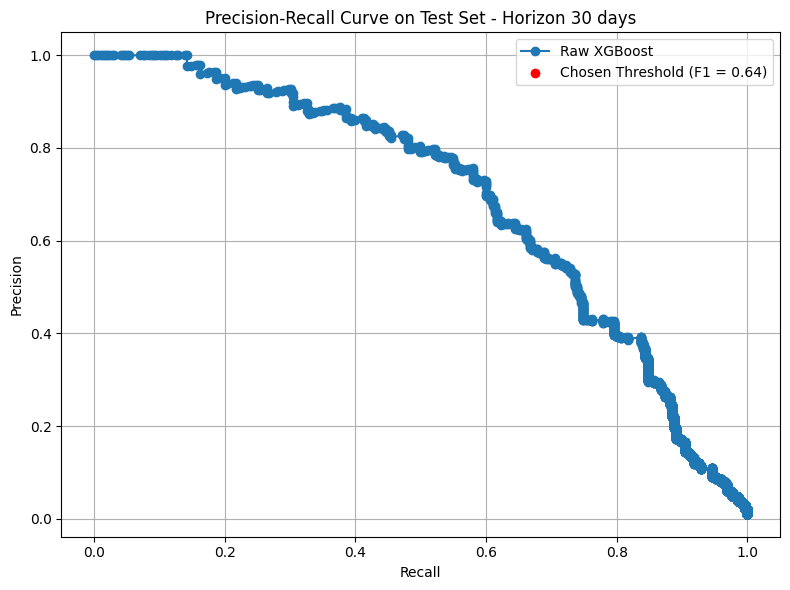

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.4970422685146332

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9816
Accuracy: 0.9933
Precision: 0.7751
Recall: 0.5492
F1 Score: 0.6429
Brier Score: 0.0055
TN: 26539, FP: 47, FN: 133, TP: 162
FNR: 0.4508, FPR: 0.0018


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.32258063554763794

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9803
Accuracy: 0.9932
Precision: 0.7303
Recall: 0.5966
F1 Score: 0.6567
Brier Score: 0.0054
TN: 26521, FP: 65, FN: 119, TP: 176
FNR: 0.4034, FPR: 0.0024


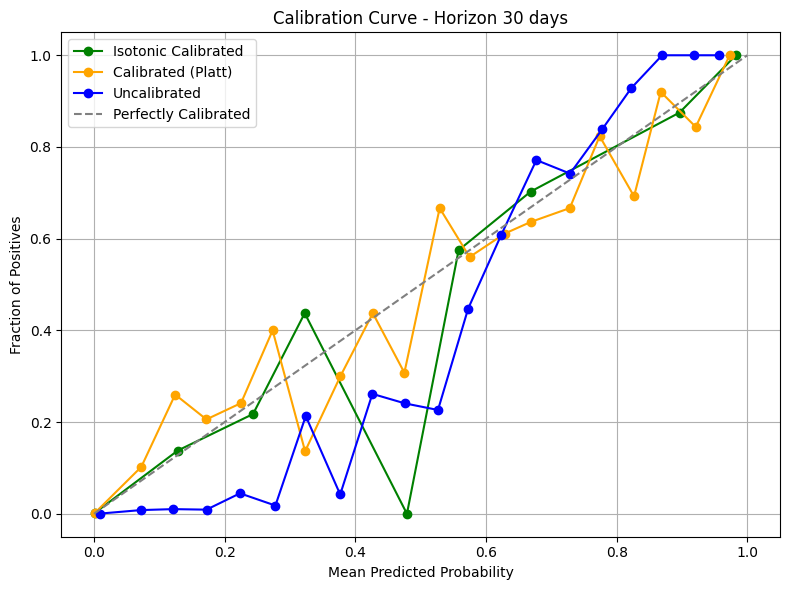

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.899
Average prediction set size: 0.90
set length 1 positives: 13, negatives: 24161, set length 2: 2707
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9920389866448421
Precision: 0.6382252559726962
Recall: 0.6338983050847458
F1 Score: 0.6360544217687075
TN: 26480, FP: 106, FN: 108, TP: 187
Specificity: 0.9960, Sensitivity: 0.6339
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9993381318772234
Precision: 1.0
Recall: 0.4482758620689655
F1 Score: 0.6190476190476191
TN: 24145, FP: 0, FN: 16, TP: 13
Specificity: 1.0000, Sensitivity: 0.4483
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9931178155574569
Precision: 0.8273809523809523
Recall: 0.4711864406779661
F1 Score: 0.6004319654427646
TN: 26557, FP: 29, FN: 156, TP: 139
Specificity: 0.9989, Sensitivity: 0.4712

===== XGBoost Tr

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:50:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.47635075
Classification report for Horizon 90 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.99      0.99     26278
   Graft Loss       0.71      0.68      0.69       603

     accuracy                           0.99     26881
    macro avg       0.85      0.84      0.84     26881
 weighted avg       0.99      0.99      0.99     26881

Brier Score (Raw XGBoost): 0.013503961906179085
ROC AUC (Raw XGBoost): 0.9852869566468594
Accuracy: 0.9864960380938209
Precision: 0.7076124567474048
Recall: 0.6782752902155887
F1 Score: 0.6926333615580017
TN: 26109, FP: 169, FN: 194, TP: 409
FNR: 0.3217, FPR: 0.0064
Specificity: 0.9936, Sensitivity: 0.6783


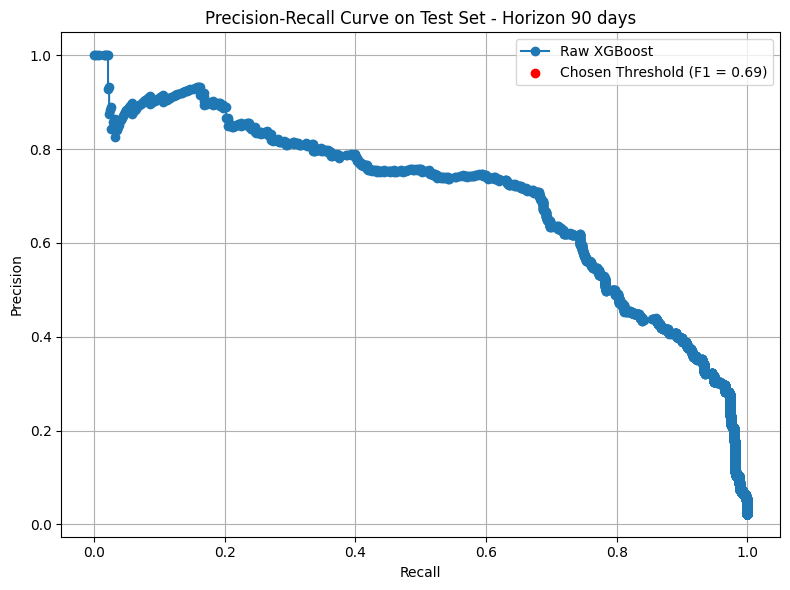

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.3104396462440491

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9853
Accuracy: 0.9865
Precision: 0.7076
Recall: 0.6783
F1 Score: 0.6926
Brier Score: 0.0111
TN: 26109, FP: 169, FN: 194, TP: 409
FNR: 0.3217, FPR: 0.0064


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.3055555522441864

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9855
Accuracy: 0.9843
Precision: 0.6349
Recall: 0.7065
F1 Score: 0.6688
Brier Score: 0.0105
TN: 26033, FP: 245, FN: 177, TP: 426
FNR: 0.2935, FPR: 0.0093


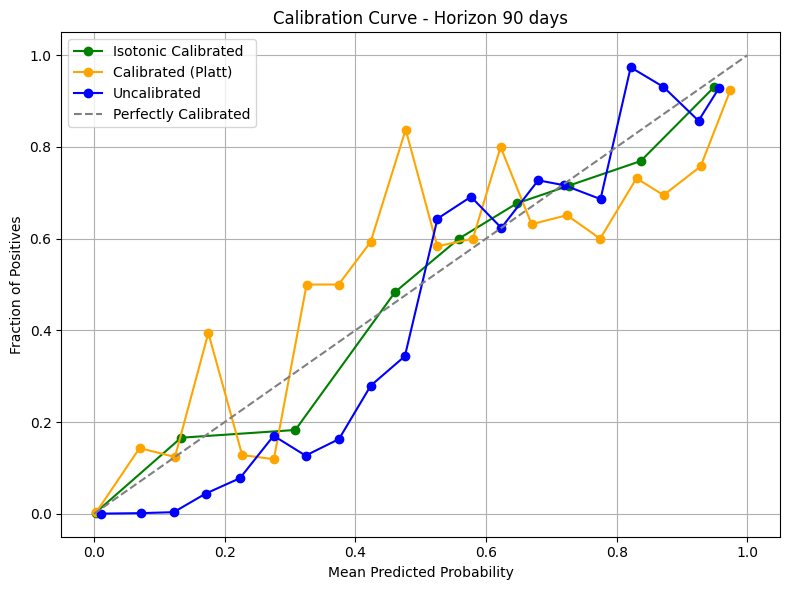

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.900
Average prediction set size: 0.90
set length 1 positives: 46, negatives: 24163, set length 2: 2672
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9864216360998475
Precision: 0.7253787878787878
Recall: 0.6351575456053068
F1 Score: 0.6772767462422635
TN: 26133, FP: 145, FN: 220, TP: 383
Specificity: 0.9945, Sensitivity: 0.6352
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9991738609607997
Precision: 0.8913043478260869
Recall: 0.7321428571428571
F1 Score: 0.803921568627451
TN: 24148, FP: 5, FN: 15, TP: 41
Specificity: 0.9998, Sensitivity: 0.7321
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9865332390908076
Precision: 0.7211009174311926
Recall: 0.6517412935323383
F1 Score: 0.6846689895470384
TN: 26126, FP: 152, FN: 210, TP: 393
Specificity: 0.9942, Sensitivity: 0.6517

=

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:50:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.38454705
Classification report for Horizon 180 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.99      0.99     25973
   Graft Loss       0.70      0.76      0.73       908

     accuracy                           0.98     26881
    macro avg       0.84      0.88      0.86     26881
 weighted avg       0.98      0.98      0.98     26881

Brier Score (Raw XGBoost): 0.01919571444514713
ROC AUC (Raw XGBoost): 0.9835729954064463
Accuracy: 0.9808042855548529
Precision: 0.6967871485943775
Recall: 0.76431718061674
F1 Score: 0.7289915966386554
TN: 25671, FP: 302, FN: 214, TP: 694
FNR: 0.2357, FPR: 0.0116
Specificity: 0.9884, Sensitivity: 0.7643


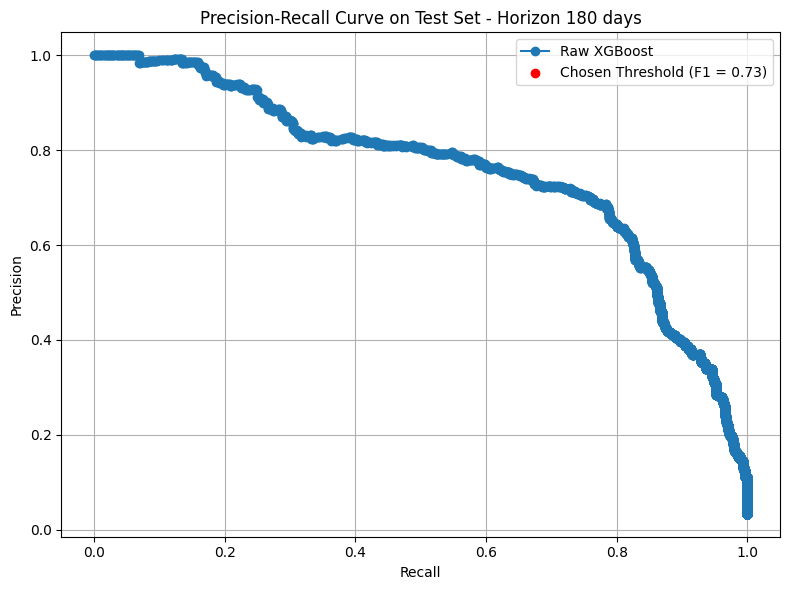

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.23901112377643585

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9836
Accuracy: 0.9808
Precision: 0.6968
Recall: 0.7643
F1 Score: 0.7290
Brier Score: 0.0149
TN: 25671, FP: 302, FN: 214, TP: 694
FNR: 0.2357, FPR: 0.0116


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.33898305892944336

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9836
Accuracy: 0.9806
Precision: 0.6863
Recall: 0.7830
F1 Score: 0.7315
Brier Score: 0.0141
TN: 25648, FP: 325, FN: 197, TP: 711
FNR: 0.2170, FPR: 0.0125


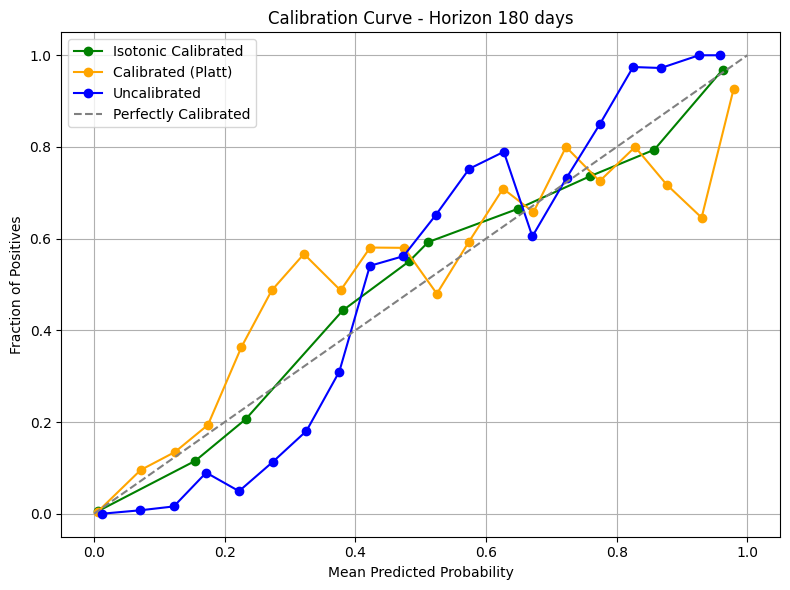

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.899
Average prediction set size: 0.90
set length 1 positives: 60, negatives: 24166, set length 2: 2655
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9802834715970388
Precision: 0.7763157894736842
Recall: 0.5848017621145375
F1 Score: 0.6670854271356784
TN: 25820, FP: 153, FN: 377, TP: 531
Specificity: 0.9941, Sensitivity: 0.5848
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9980599356063733
Precision: 1.0
Recall: 0.5607476635514018
F1 Score: 0.718562874251497
TN: 24119, FP: 0, FN: 47, TP: 60
Specificity: 1.0000, Sensitivity: 0.5607
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9808042855548529
Precision: 0.6967871485943775
Recall: 0.76431718061674
F1 Score: 0.7289915966386554
TN: 25671, FP: 302, FN: 214, TP: 694
Specificity: 0.9884, Sensitivity: 0.7643

===== XGBoost Trai

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:51:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.3539021
Classification report for Horizon 360 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.99      0.99     25512
   Graft Loss       0.76      0.79      0.78      1369

     accuracy                           0.98     26881
    macro avg       0.87      0.89      0.88     26881
 weighted avg       0.98      0.98      0.98     26881

Brier Score (Raw XGBoost): 0.023362226107659687
ROC AUC (Raw XGBoost): 0.9879709853378842
Accuracy: 0.9766377738923403
Precision: 0.7581881533101046
Recall: 0.7947406866325786
F1 Score: 0.776034236804565
TN: 25165, FP: 347, FN: 281, TP: 1088
FNR: 0.2053, FPR: 0.0136
Specificity: 0.9864, Sensitivity: 0.7947


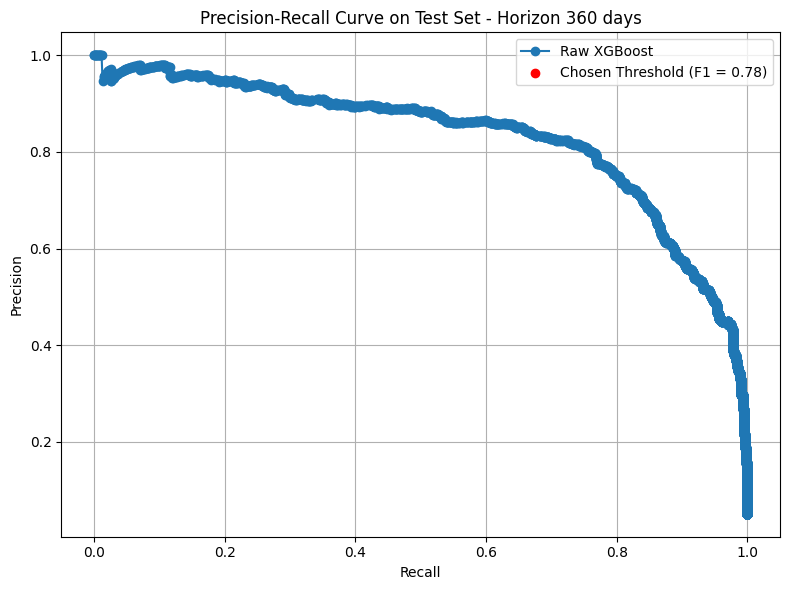

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.24183963239192963

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9880
Accuracy: 0.9766
Precision: 0.7582
Recall: 0.7947
F1 Score: 0.7760
Brier Score: 0.0177
TN: 25165, FP: 347, FN: 281, TP: 1088
FNR: 0.2053, FPR: 0.0136


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.31111112236976624

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9879
Accuracy: 0.9750
Precision: 0.7228
Recall: 0.8247
F1 Score: 0.7704
Brier Score: 0.0169
TN: 25079, FP: 433, FN: 240, TP: 1129
FNR: 0.1753, FPR: 0.0170


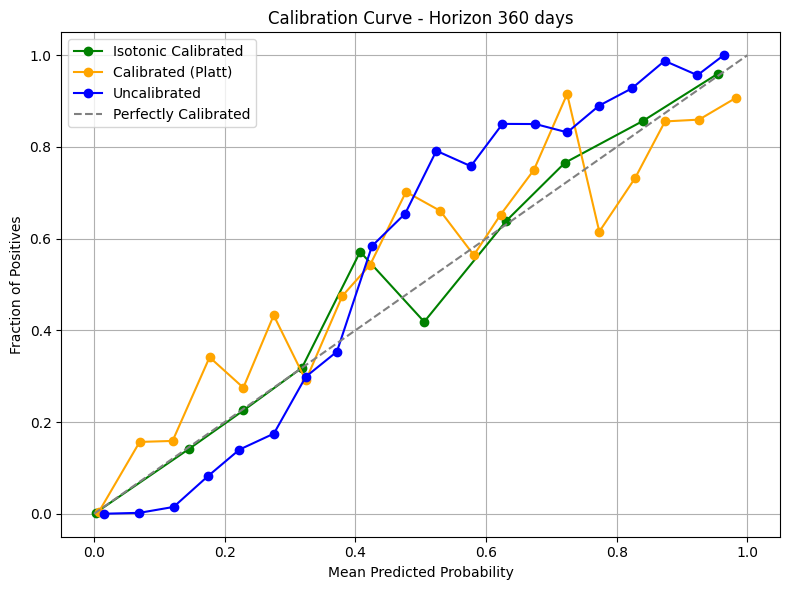

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.903
Average prediction set size: 0.91
set length 1 positives: 192, negatives: 24141, set length 2: 2548
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9753357389978051
Precision: 0.8580121703853956
Recall: 0.6179693206720234
F1 Score: 0.7184713375796178
TN: 25372, FP: 140, FN: 523, TP: 846
Specificity: 0.9945, Sensitivity: 0.6180
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9970410553569227
Precision: 0.9583333333333334
Recall: 0.7419354838709677
F1 Score: 0.8363636363636363
TN: 24077, FP: 8, FN: 64, TP: 184
Specificity: 0.9997, Sensitivity: 0.7419
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9766377738923403
Precision: 0.7581881533101046
Recall: 0.7947406866325786
F1 Score: 0.776034236804565
TN: 25165, FP: 347, FN: 281, TP: 1088
Specificity: 0.9864, Sensitivity: 0.7947

In [ ]:
# graft loss prediction
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE, ADASYN
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib


for H in horizons:
    event_name = f'GraftLoss@{H}'
    print(f"\n===== XGBoost Training for Horizon {H} days =====")
    # Convert data to tensors
    X_train = torch.tensor(train_graft_repr_p[H], dtype=torch.float32)
    y_train = torch.tensor(train_graft_lbl_p[H], dtype=torch.float32)

    # Step 1: Original test set (30% of full data)
    X_test = test_graft_repr[H]
    y_test = test_graft_lbl[H]

    X_val = val_graft_repr[H]
    y_val = val_graft_lbl[H]

    up_sampling_SMOTE = False
    up_sampling_ADASYN = True

    if up_sampling_ADASYN:
        # apply ADASYN
        print("Applying ADASYN for upsampling...")
        smote = ADASYN(random_state=0, sampling_strategy=0.5)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After ADASYN: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    elif up_sampling_SMOTE:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    else:
        print("No upsampling applied.")

    # Train XGBoost
    xgboost_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train) / 6,
        eval_metric=['aucpr', 'logloss'],
        objective='binary:logistic',
        random_state=0,
        max_delta_step=10,
    )
    print(f"Scale pos weight: {xgboost_model.get_params()['scale_pos_weight']:.4f}")
    xgboost_model.fit(X_train, y_train)

    # save model
    xgboost_model.save_model(f'../models/{event_name}_xgboost_raw.pkl')

    # Tune threshold on validation set
    y_prob_val = xgboost_model.predict_proba(X_val)[:, 1]
    precision, recall, thresh = precision_recall_curve(y_val, y_prob_val)
    precision = precision[1:]
    recall = recall[1:]

    # F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero

    # Vectorized cost computation
    y_preds = (y_prob_val[None, :] >= thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs = fp * cost_fp + fn * cost_fn

    # Normalize
    f1_norm = f1_scores
    costs_norm = 1 - (costs - np.min(costs)) / (np.max(costs) - np.min(costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score = alpha * f1_norm + beta * costs_norm

    optimal_threshold = thresh[np.argmax(hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost):", optimal_threshold)

    # Predict on xgboost
    y_prob_raw = xgboost_model.predict_proba(X_test)[:, 1]
    y_pred_base = (y_prob_raw >= optimal_threshold).astype(int)
    print(f"Classification report for Horizon {H} days:")
    print(classification_report(y_test, y_pred_base, target_names=['No Graft Loss', 'Graft Loss']))
    print("Brier Score (Raw XGBoost):", brier_score_loss(y_test, y_pred_base))
    print("ROC AUC (Raw XGBoost):", roc_auc_score(y_test, y_prob_raw))
    print("Accuracy:", accuracy_score(y_test, y_pred_base))
    print("Precision:", precision_score(y_test, y_pred_base))
    print("Recall:", recall_score(y_test, y_pred_base))
    print("F1 Score:", f1_score(y_test, y_pred_base))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FNR: {fn / (tp + fn):.4f}, FPR: {fp / (tn + fp):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # plot PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_raw)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', label='Raw XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on Test Set - Horizon {H} days')
    # Compute metrics at chosen threshold on test set
    precision_test = precision_score(y_test, y_pred_base)
    recall_test = recall_score(y_test, y_pred_base)
    plt.scatter(recall_test, precision_test, color='red', label=f'Chosen Threshold (F1 = {f1_score(y_test, y_pred_base):.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Apply Platt scaling (calibration)
    platt_calibrator = CalibratedClassifierCV(xgboost_model, method='sigmoid', cv='prefit')
    platt_calibrator.fit(X_val, y_val)
    y_prob_cal_val = platt_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_cal_test = platt_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save calibrated model
    joblib.dump(platt_calibrator, f'../models/{event_name}_platt_raw.pkl')

    # Debug: Check calibrated probability distribution
    #print(f"Calibrated Probabilities (Test) - Min: {np.min(y_prob_cal_test):.4f}, Max: {np.max(y_prob_cal_test):.4f}")
    #print(f"Calibrated Probabilities (Test) - Histogram: {np.histogram(y_prob_cal_test, bins=10)[0]}")
    
    platt_precision, platt_recall, platt_thresh = precision_recall_curve(y_val, y_prob_cal_val)

    platt_precision = platt_precision[1:]
    platt_recall = platt_recall[1:]

    # F1
    platt_f1_scores = 2 * (platt_precision * platt_recall) / (platt_precision + platt_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_cal_val[None, :] >= platt_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp_p = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp_p = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn_p = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs_p = fp_p * cost_fp + fn_p * cost_fn

    # Normalize
    platt_f1_norm = platt_f1_scores
    costs_norm_p = 1 - (costs_p - np.min(costs_p)) / (np.max(costs_p) - np.min(costs_p))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score_p = alpha * platt_f1_norm + beta * costs_norm_p

    platt_optimal_threshold = platt_thresh[np.argmax(hybrid_score_p)]
    print("Optimal threshold (hybrid F1 + cost) Platt scaling:", platt_optimal_threshold)

    # Evaluate calibrated predictions
    y_pred_cal_test = (y_prob_cal_test >= platt_optimal_threshold).astype(int)
    tn_cal, fp_cal, fn_cal, tp_cal = confusion_matrix(y_test, y_pred_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Platt Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_cal_test):.4f}")
    print(f"TN: {tn_cal}, FP: {fp_cal}, FN: {fn_cal}, TP: {tp_cal}")
    print(f"FNR: {fn_cal / (tp_cal + fn_cal):.4f}, FPR: {fp_cal / (tn_cal + fp_cal):.4f}")

    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal_test, n_bins=20)
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, y_prob_raw, n_bins=20)

    # Try istonic calibration
    iso_calibrator = CalibratedClassifierCV(xgboost_model, method='isotonic', cv='prefit')
    iso_calibrator.fit(X_val, y_val)
    y_prob_isotonic_cal_val = iso_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_isotonic_cal_test = iso_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save isotonic calibrated model
    joblib.dump(iso_calibrator, f'../models/{event_name}_iso_raw.pkl')
    
    iso_precision, iso_recall, iso_thresh = precision_recall_curve(y_val, y_prob_isotonic_cal_val)

    iso_precision = iso_precision[1:]
    iso_recall = iso_recall[1:]

    # F1
    iso_f1_scores = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_isotonic_cal_val[None, :] >= iso_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    iso_tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    iso_fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    iso_fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    iso_costs = iso_fp * cost_fp + iso_fn * cost_fn

    # Normalize
    iso_f1_norm = iso_f1_scores
    iso_costs_norm = 1 - (iso_costs - np.min(iso_costs)) / (np.max(iso_costs) - np.min(iso_costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    iso_hybrid_score = alpha * iso_f1_norm + beta * iso_costs_norm

    iso_optimal_threshold = iso_thresh[np.argmax(iso_hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost) Isotonic:", iso_optimal_threshold)

    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= iso_optimal_threshold).astype(int)
    tn_iso, fp_iso, fn_iso, tp_iso = confusion_matrix(y_test, y_pred_isotonic_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Isotonic Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_isotonic_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"TN: {tn_iso}, FP: {fp_iso}, FN: {fn_iso}, TP: {tp_iso}")
    print(f"FNR: {fn_iso / (tp_iso + fn_iso):.4f}, FPR: {fp_iso / (tn_iso + fp_iso):.4f}")
    # Plot calibration curve for isotonic regression
    plt.figure(figsize=(8, 6))
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_isotonic_cal_test, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Calibrated', color='green')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated (Platt)', color='orange')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Uncalibrated', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - Horizon {H} days')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    threshold_data = {
        'xgboost_threshold': float(optimal_threshold),
        'platt_threshold': float(platt_optimal_threshold),
        'iso_threshold': float(iso_optimal_threshold)
    }

    with open(f'../models/{event_name}_thresholds_raw.json', 'w') as f:
        json.dump(threshold_data, f, indent=4)


    print("Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...")
    mapie_clf = MapieClassifier(estimator=xgboost_model, cv="prefit", method="lac")
    mapie_clf.fit(X_val, y_val)
    y_pred, y_psets = mapie_clf.predict(X_test, alpha=0.1)
    y_psets = y_psets[:, :, 0]
    y_test = np.array(y_test).astype(int)
    coverage = classification_coverage_score(y_test, y_psets)
    print(f"Prediction set coverage (expected ~0.9): {coverage:.3f}")
    avg_set_size = np.mean(np.sum(y_psets, axis=1))
    print(f"Average prediction set size: {avg_set_size:.2f}")
    set_1_p = 0
    set_1_n = 0
    set_2 = 0

    for i in range(len(y_test)):
        pred_set = y_psets[i]
        labels_in_set = np.where(pred_set)[0]
        if len(labels_in_set) == 1:
            if labels_in_set[0] == 1:
                set_1_p += 1
            else:
                set_1_n += 1
        else:
            set_2 += 1
        
    print(f"set length 1 positives: {set_1_p}, negatives: {set_1_n}, set length 2: {set_2}")

    is_singleton = np.sum(y_psets, axis=1) == 1
    y_pred_filtered = y_pred[is_singleton]
    y_true_filtered = y_test[is_singleton]

    # Metrics for default y_pred
    print("====== Metrics on single-label predictions (confident + ambigous (default))=======")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    print("====== Metrics on single-label predictions (confident) ======")
    print("Accuracy:", accuracy_score(y_true_filtered, y_pred_filtered))
    print("Precision:", precision_score(y_true_filtered, y_pred_filtered))
    print("Recall:", recall_score(y_true_filtered, y_pred_filtered))
    print("F1 Score:", f1_score(y_true_filtered, y_pred_filtered))
    tn, fp, fn, tp = confusion_matrix(y_true_filtered, y_pred_filtered).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # Find singleton vs ambiguous predictions
    singleton_mask = np.sum(y_psets, axis=1) == 1

    # Use calibrated model to predict probabilities for uncertain samples
    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= optimal_threshold).astype(int)

    # Combine predictions
    final_preds = np.copy(y_pred)
    final_preds[~singleton_mask] = y_pred_isotonic_cal_test[~singleton_mask]

    print("====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======")
    print("Accuracy:", accuracy_score(y_test, final_preds))
    print("Precision:", precision_score(y_test, final_preds))
    print("Recall:", recall_score(y_test, final_preds))
    print("F1 Score:", f1_score(y_test, final_preds))
    tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")


In [11]:
# mortality
horizons = [30, 90, 180, 360]
model = model.to(device)
train_mort_repr, train_mort_lbl, train_mort_days, train_mort_pids, train_mort_days = extract_horizon_reps(model, train_dataloader, horizons, 'death_label', 'death_rel_days')
test_mort_repr, test_mort_lbl, test_mort_days, test_mort_pids, test_mort_days = extract_horizon_reps(model, test_dataloader, horizons, 'death_label', 'death_rel_days')

# Initialize dictionaries with same structure but with _p suffix
train_mort_repr_p = {H: None for H in horizons}
test_mort_repr_p = {H: None for H in horizons}
train_mort_lbl_p = {H: None for H in horizons}
test_mort_lbl_p = {H: None for H in horizons}

undersample_ratio = 0.4  # Ratio of negative to positive samples in the undersampled dataset
random_state = 42  # For reproducibility

# Print stats and process each dataset for all horizons
for H in horizons:
    print(f"\n===== Original Extracted Features for Horizon {H} days =====")
    print(f"Mortality Training: {train_mort_repr[H].shape}, Positive: {sum(train_mort_lbl[H])}, Ratio: {sum(train_mort_lbl[H])/len(train_mort_lbl[H]):.4f}")
    print(f"Mortality Testing: {test_mort_repr[H].shape}, Positive: {sum(test_mort_lbl[H])}, Ratio: {sum(test_mort_lbl[H])/len(test_mort_lbl[H]):.4f}")
    
    # Process graft loss data
    print(f"\n--- Processing Mortality data for horizon {H} ---")
    # Combine train and test to get a full dataset before new stratified split
    X_mort = np.vstack((train_mort_repr[H], test_mort_repr[H]))
    y_mort = np.concatenate((train_mort_lbl[H], test_mort_lbl[H]))
    
    # Get the indices of negative and positive samples
    neg_indices = np.where(y_mort == 0)[0]
    pos_indices = np.where(y_mort == 1)[0]
    
    # Randomly select subset of negative samples
    np.random.seed(random_state)
    neg_indices_subset = np.random.choice(neg_indices, size=int(undersample_ratio * len(neg_indices)), replace=False)
    
    # Combine with all positive samples
    selected_indices = np.concatenate([neg_indices_subset, pos_indices])
    
    # Create the balanced subset
    X_subset = X_mort[selected_indices]
    y_subset = y_mort[selected_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, 
        test_size=test_size, 
        stratify=y_subset,
        random_state=random_state
    )
    
    # Store processed data with _p suffix
    train_mort_repr_p[H] = X_train
    test_mort_repr_p[H] = X_test
    train_mort_lbl_p[H] = y_train
    test_mort_lbl_p[H] = y_test
    
    print(f"Undersampled Mortality:")
    print(f"Train: {len(train_mort_lbl_p[H])} samples, {sum(train_mort_lbl_p[H])} positives ({sum(train_mort_lbl_p[H])/len(train_mort_lbl_p[H]):.4f})")
    print(f"Test: {len(test_mort_lbl_p[H])} samples, {sum(test_mort_lbl_p[H])} positives ({sum(test_mort_lbl_p[H])/len(test_mort_lbl_p[H]):.4f})")

100%|██████████| 68/68 [01:14<00:00,  1.10s/it]


Horizon 30: 2164 patients, avg 87.7 samples/patient, max 199 samples/patient
Horizon 90: 2164 patients, avg 87.7 samples/patient, max 199 samples/patient
Horizon 180: 2164 patients, avg 87.7 samples/patient, max 199 samples/patient
Horizon 360: 2164 patients, avg 87.7 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Horizon 30: 931 patients, avg 88.3 samples/patient, max 199 samples/patient
Horizon 90: 931 patients, avg 88.3 samples/patient, max 199 samples/patient
Horizon 180: 931 patients, avg 88.3 samples/patient, max 199 samples/patient
Horizon 360: 931 patients, avg 88.3 samples/patient, max 199 samples/patient

===== Original Extracted Features for Horizon 30 days =====
Mortality Training: (189845, 32), Positive: 2840, Ratio: 0.0150
Mortality Testing: (82180, 32), Positive: 1255, Ratio: 0.0153

--- Processing Mortality data for horizon 30 ---
Undersampled Mortality:
Train: 110336 samples, 4061 positives (0.0368)
Test: 931 samples, 34 positives (0.0365)

===== Original Extracted Features for Horizon 90 days =====
Mortality Training: (189845, 32), Positive: 6195, Ratio: 0.0326
Mortality Testing: (82180, 32), Positive: 2885, Ratio: 0.0351

--- Processing Mortality data for horizon 90 ---
Undersampled Mortality:
Train: 113327 samples, 9006 positives (0.0795)
Test: 931 samples, 74 positives (0.07

In [ ]:
# construct validation set Mortality
val_mort_repr = {H: None for H in horizons}
val_mort_lbl = {H: None for H in horizons}

for H in horizons:
    # Original test set (30% of full data)
    X_test_full = torch.tensor(test_mort_repr[H], dtype=torch.float32)
    y_test_full = torch.tensor(test_mort_lbl[H], dtype=torch.float32)

    # Split 2/3 for validation (20%) and 1/3 for final test (10%)
    val_mort_repr[H], test_mort_repr[H], val_mort_lbl[H], test_mort_lbl[H] = train_test_split(
        X_test_full, y_test_full,
        test_size=1/3,  # 10% out of 30% = 1/3
        stratify=y_test_full,
        random_state=42
    )

# Print validation set stats
for H in horizons:
    print(f"\nValidation set for Horizon {H} days:")
    print(f"Samples: {len(val_mort_lbl[H])}, Positives: {sum(val_mort_lbl[H])} ({sum(val_mort_lbl[H])/len(val_mort_lbl[H]):.4f})")
    print(f"Test set for Horizon {H} days:")
    print(f"Samples: {len(test_mort_lbl[H])}, Positives: {sum(test_mort_lbl[H])} ({sum(test_mort_lbl[H])/len(test_mort_lbl[H]):.4f})")


Validation set for Horizon 30 days:
Samples: 54786, Positives: 837.0 (0.0153)
Test set for Horizon 30 days:
Samples: 27394, Positives: 418.0 (0.0153)

Validation set for Horizon 90 days:
Samples: 54786, Positives: 1923.0 (0.0351)
Test set for Horizon 90 days:
Samples: 27394, Positives: 962.0 (0.0351)

Validation set for Horizon 180 days:
Samples: 54786, Positives: 2922.0 (0.0533)
Test set for Horizon 180 days:
Samples: 27394, Positives: 1461.0 (0.0533)

Validation set for Horizon 360 days:
Samples: 54786, Positives: 4165.0 (0.0760)
Test set for Horizon 360 days:
Samples: 27394, Positives: 2082.0 (0.0760)



===== XGBoost Training for Horizon 30 days =====
Applying ADASYN for upsampling...
After ADASYN: (159474, 32), Positives: 53199.0 (0.3336)
Scale pos weight: 0.3329


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:15:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.50128764
Classification report for Horizon 30 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      1.00      1.00     26976
   Graft Loss       0.71      0.68      0.70       418

     accuracy                           0.99     27394
    macro avg       0.85      0.84      0.85     27394
 weighted avg       0.99      0.99      0.99     27394

Brier Score (Raw XGBoost): 0.009053077316200628
ROC AUC (Raw XGBoost): 0.9893863214226929
Accuracy: 0.9909469226837994
Precision: 0.7114427860696517
Recall: 0.6842105263157895
F1 Score: 0.697560975609756
TN: 26860, FP: 116, FN: 132, TP: 286
FNR: 0.3158, FPR: 0.0043
Specificity: 0.9957, Sensitivity: 0.6842


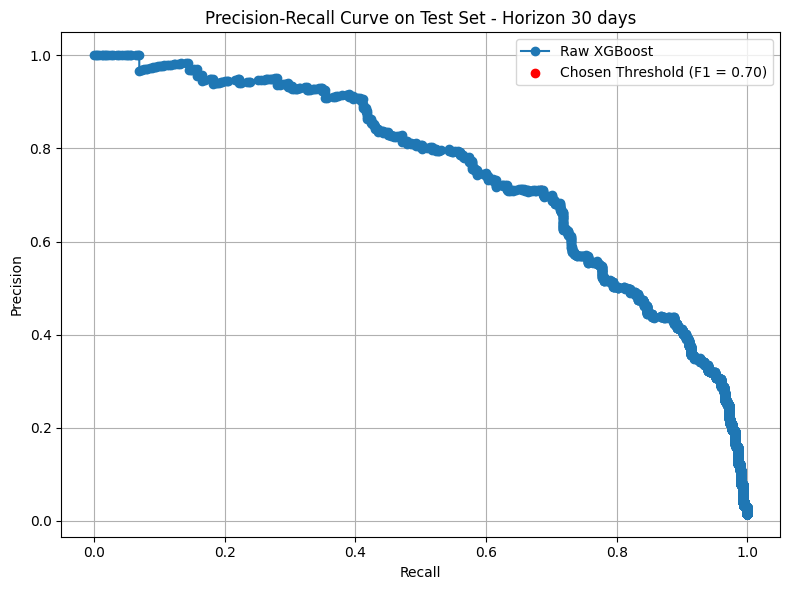

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.37387436628341675

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9894
Accuracy: 0.9909
Precision: 0.7114
Recall: 0.6842
F1 Score: 0.6976
Brier Score: 0.0070
TN: 26860, FP: 116, FN: 132, TP: 286
FNR: 0.3158, FPR: 0.0043
Specificity: 0.9957, Sensitivity: 0.6842


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.27906978130340576

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9879
Accuracy: 0.9908
Precision: 0.6993
Recall: 0.7010
F1 Score: 0.7001
Brier Score: 0.0067
TN: 26850, FP: 126, FN: 125, TP: 293
FNR: 0.2990, FPR: 0.0047
Specificity: 0.9953, Sensitivity: 0.7010


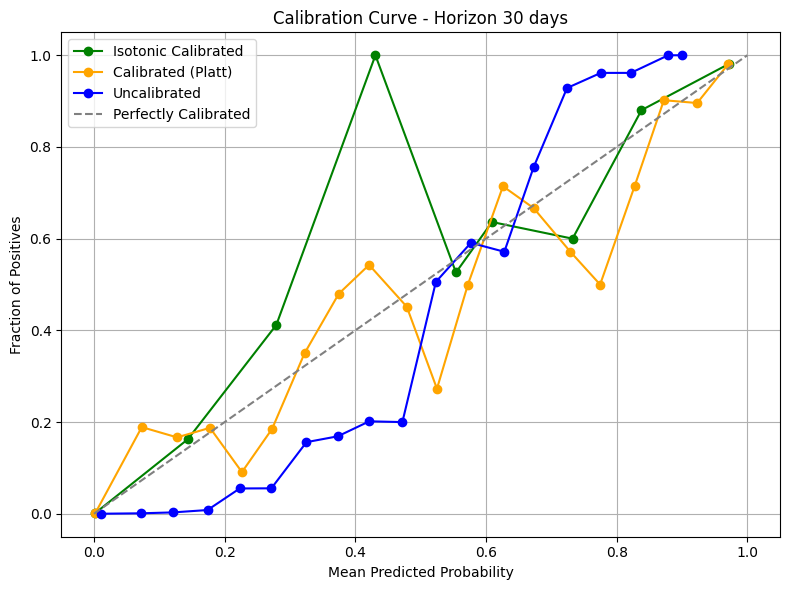

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.896
Average prediction set size: 0.90
set length 1 positives: 6, negatives: 24552, set length 2: 2836
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9909104183397824
Precision: 0.7096774193548387
Recall: 0.6842105263157895
F1 Score: 0.6967113276492083
TN: 26859, FP: 117, FN: 132, TP: 286
Specificity: 0.9957, Sensitivity: 0.6842
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9997556804300024
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
TN: 24546, FP: 0, FN: 6, TP: 6
Specificity: 1.0000, Sensitivity: 0.5000
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9909104183397824
Precision: 0.7107231920199502
Recall: 0.6818181818181818
F1 Score: 0.6959706959706959
TN: 26860, FP: 116, FN: 133, TP: 285
Specificity: 0.9957, Sensitivity: 0.6818

===== XGBoost Training for Horizo

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:16:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.41891766
Classification report for Horizon 90 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.99      0.99     26432
   Graft Loss       0.71      0.78      0.74       962

     accuracy                           0.98     27394
    macro avg       0.85      0.88      0.87     27394
 weighted avg       0.98      0.98      0.98     27394

Brier Score (Raw XGBoost): 0.018726728480689202
ROC AUC (Raw XGBoost): 0.9830539543198442
Accuracy: 0.9812732715193108
Precision: 0.7144221585482331
Recall: 0.7775467775467776
F1 Score: 0.7446490791438527
TN: 26133, FP: 299, FN: 214, TP: 748
FNR: 0.2225, FPR: 0.0113
Specificity: 0.9887, Sensitivity: 0.7775


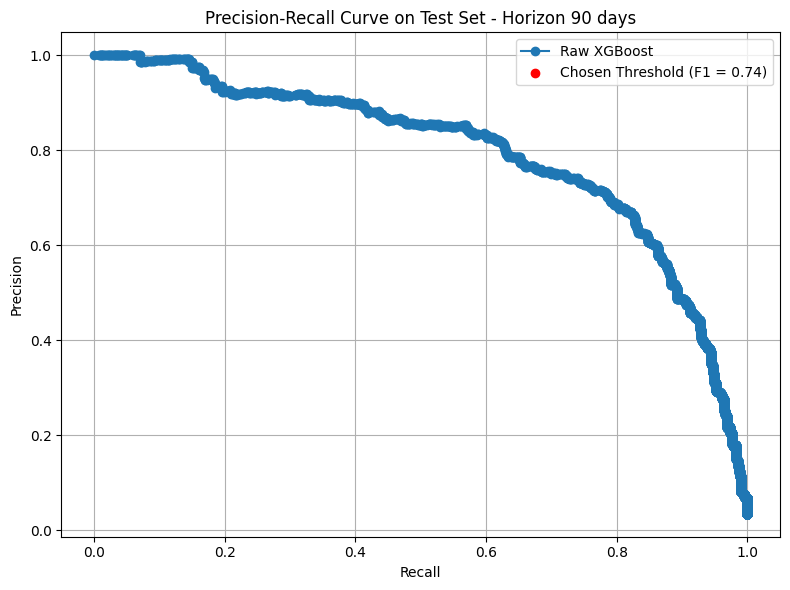

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.2851073145866394

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9831
Accuracy: 0.9813
Precision: 0.7144
Recall: 0.7775
F1 Score: 0.7446
Brier Score: 0.0137
TN: 26133, FP: 299, FN: 214, TP: 748
FNR: 0.2225, FPR: 0.0113
Specificity: 0.9887, Sensitivity: 0.7775


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.336448609828949

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9840
Accuracy: 0.9799
Precision: 0.6789
Recall: 0.8108
F1 Score: 0.7390
Brier Score: 0.0134
TN: 26063, FP: 369, FN: 182, TP: 780
FNR: 0.1892, FPR: 0.0140
Specificity: 0.9860, Sensitivity: 0.8108


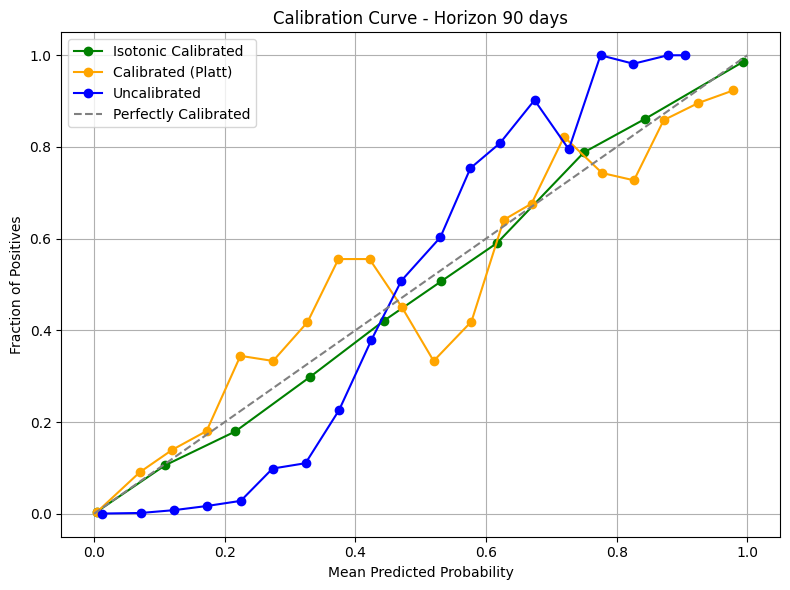

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.900
Average prediction set size: 0.90
set length 1 positives: 98, negatives: 24612, set length 2: 2684
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9816018106154633
Precision: 0.8045212765957447
Recall: 0.6288981288981289
F1 Score: 0.705950991831972
TN: 26285, FP: 147, FN: 357, TP: 605
Specificity: 0.9944, Sensitivity: 0.6289
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9979765277215702
Precision: 0.9897959183673469
Recall: 0.6643835616438356
F1 Score: 0.7950819672131147
TN: 24563, FP: 1, FN: 49, TP: 97
Specificity: 1.0000, Sensitivity: 0.6644
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9812732715193108
Precision: 0.7144221585482331
Recall: 0.7775467775467776
F1 Score: 0.7446490791438527
TN: 26133, FP: 299, FN: 214, TP: 748
Specificity: 0.9887, Sensitivity: 0.7775

=

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:16:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.37926432
Classification report for Horizon 180 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.98      0.99     25933
   Graft Loss       0.72      0.82      0.77      1461

     accuracy                           0.97     27394
    macro avg       0.86      0.90      0.88     27394
 weighted avg       0.98      0.97      0.97     27394

Brier Score (Raw XGBoost): 0.026538658100313937
ROC AUC (Raw XGBoost): 0.9852111399688869
Accuracy: 0.973461341899686
Precision: 0.7216183574879227
Recall: 0.8179329226557153
F1 Score: 0.766762913057427
TN: 25472, FP: 461, FN: 266, TP: 1195
FNR: 0.1821, FPR: 0.0178
Specificity: 0.9822, Sensitivity: 0.8179


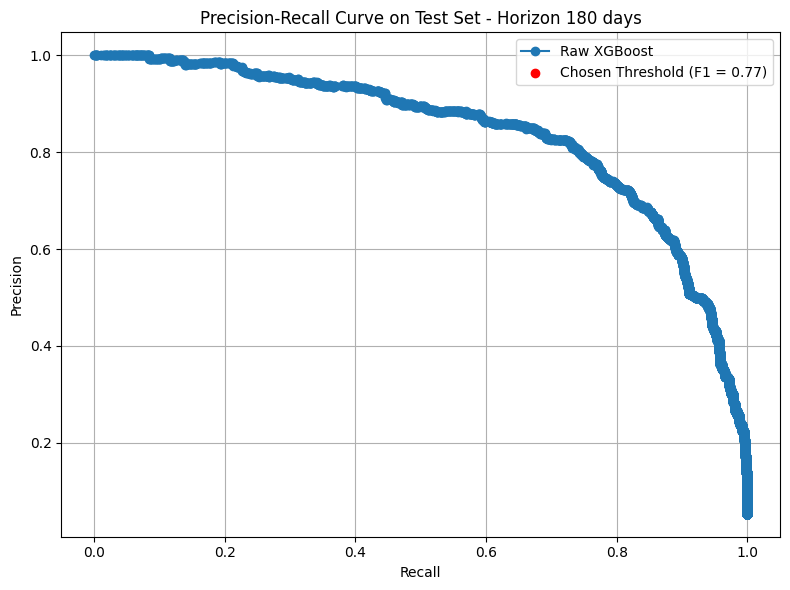

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.24501247704029083

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9852
Accuracy: 0.9735
Precision: 0.7216
Recall: 0.8179
F1 Score: 0.7668
Brier Score: 0.0182
TN: 25472, FP: 461, FN: 266, TP: 1195
FNR: 0.1821, FPR: 0.0178
Specificity: 0.9822, Sensitivity: 0.8179


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.3490099012851715

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9855
Accuracy: 0.9735
Precision: 0.7221
Recall: 0.8179
F1 Score: 0.7670
Brier Score: 0.0178
TN: 25473, FP: 460, FN: 266, TP: 1195
FNR: 0.1821, FPR: 0.0177
Specificity: 0.9823, Sensitivity: 0.8179


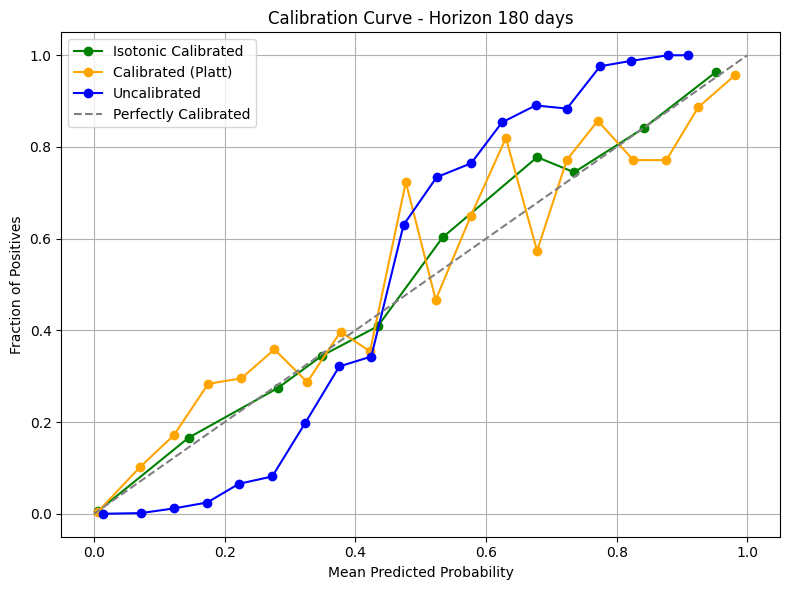

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.904
Average prediction set size: 0.91
set length 1 positives: 255, negatives: 24595, set length 2: 2544
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9751770460684821
Precision: 0.8585858585858586
Recall: 0.6399726214921286
F1 Score: 0.7333333333333333
TN: 25779, FP: 154, FN: 526, TP: 935
Specificity: 0.9941, Sensitivity: 0.6400
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9960965794768611
Precision: 0.984313725490196
Recall: 0.7296511627906976
F1 Score: 0.8380634390651085
TN: 24502, FP: 4, FN: 93, TP: 251
Specificity: 0.9998, Sensitivity: 0.7297
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9757611155727531
Precision: 0.7746381805651275
Recall: 0.7693360711841205
F1 Score: 0.771978021978022
TN: 25606, FP: 327, FN: 337, TP: 1124
Specificity: 0.9874, Sensitivity: 0.7693


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [13:16:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.35413474
Classification report for Horizon 360 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.98      0.98     25312
   Graft Loss       0.74      0.83      0.78      2082

     accuracy                           0.96     27394
    macro avg       0.86      0.90      0.88     27394
 weighted avg       0.97      0.96      0.97     27394

Brier Score (Raw XGBoost): 0.035628239760531505
ROC AUC (Raw XGBoost): 0.9817838694893681
Accuracy: 0.9643717602394685
Precision: 0.7365269461077845
Recall: 0.8270893371757925
F1 Score: 0.779185520361991
TN: 24696, FP: 616, FN: 360, TP: 1722
FNR: 0.1729, FPR: 0.0243
Specificity: 0.9757, Sensitivity: 0.8271


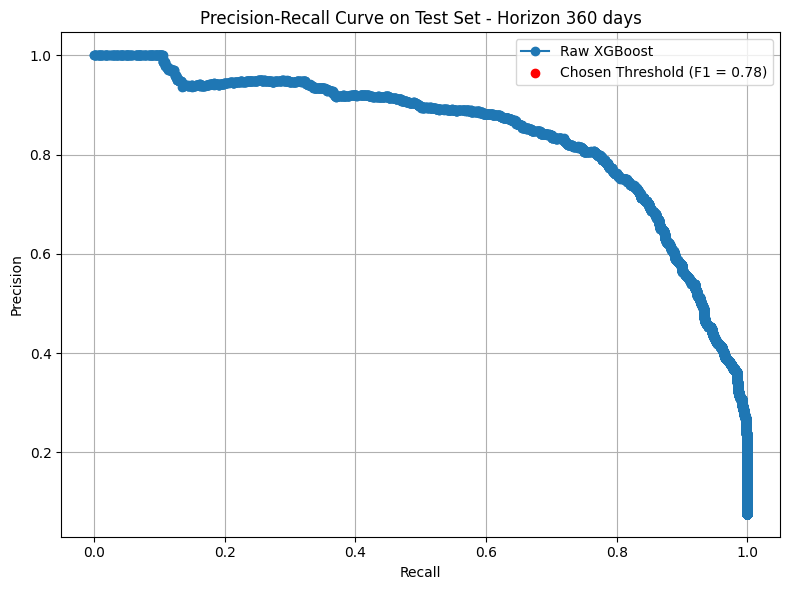

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.24312900006771088

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9818
Accuracy: 0.9644
Precision: 0.7365
Recall: 0.8271
F1 Score: 0.7792
Brier Score: 0.0252
TN: 24696, FP: 616, FN: 360, TP: 1722
FNR: 0.1729, FPR: 0.0243
Specificity: 0.9757, Sensitivity: 0.8271


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.2990867495536804

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9819
Accuracy: 0.9602
Precision: 0.6945
Recall: 0.8506
F1 Score: 0.7647
Brier Score: 0.0248
TN: 24533, FP: 779, FN: 311, TP: 1771
FNR: 0.1494, FPR: 0.0308
Specificity: 0.9692, Sensitivity: 0.8506


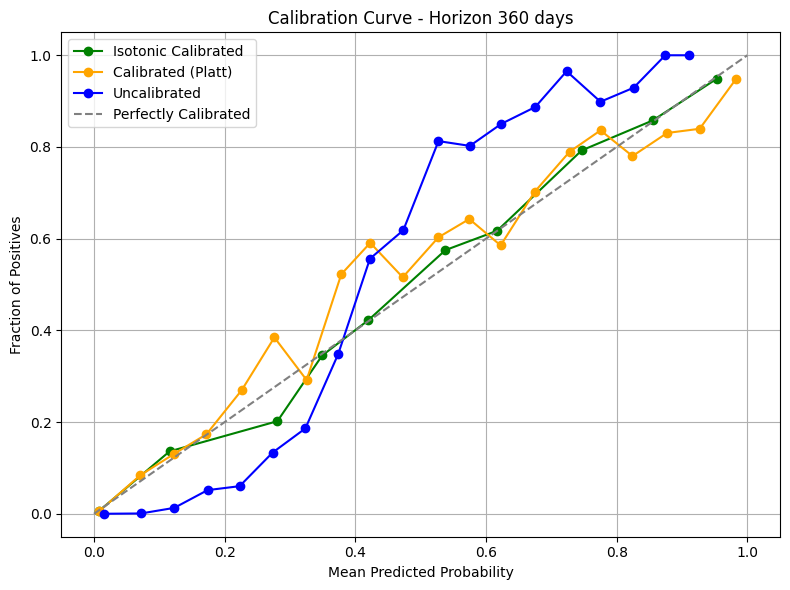

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.900
Average prediction set size: 0.91
set length 1 positives: 526, negatives: 24387, set length 2: 2481
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9644812732715193
Precision: 0.8795345653661876
Recall: 0.617195004803074
F1 Score: 0.725373976855772
TN: 25136, FP: 176, FN: 797, TP: 1285
Specificity: 0.9930, Sensitivity: 0.6172
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9891622847509333
Precision: 0.9486692015209125
Recall: 0.6725067385444744
F1 Score: 0.7870662460567823
TN: 24144, FP: 27, FN: 243, TP: 499
Specificity: 0.9989, Sensitivity: 0.6725
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9672556034168066
Precision: 0.7858176555716353
Recall: 0.7824207492795389
F1 Score: 0.784115523465704
TN: 24868, FP: 444, FN: 453, TP: 1629
Specificity: 0.9825, Sensitivity: 0.782

In [ ]:
# mortality prediction
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE, ADASYN
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib


for H in horizons:
    event_name = f'Mortality@{H}'
    print(f"\n===== XGBoost Training for Horizon {H} days =====")
    # Convert data to tensors
    X_train = torch.tensor(train_mort_repr_p[H], dtype=torch.float32)
    y_train = torch.tensor(train_mort_lbl_p[H], dtype=torch.float32)

    # Original test set (30% of full data)
    X_test = test_mort_repr[H]
    y_test = test_mort_lbl[H]

    X_val = val_mort_repr[H]
    y_val = val_mort_lbl[H]

    up_sampling_SMOTE = False
    up_sampling_ADASYN = True

    if up_sampling_ADASYN:
        # apply ADASYN
        print("Applying ADASYN for upsampling...")
        smote = ADASYN(random_state=0, sampling_strategy=0.5)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After ADASYN: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    elif up_sampling_SMOTE:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    else:
        print("No upsampling applied.")

    # Train XGBoost
    xgboost_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train) / 6,
        eval_metric=['aucpr', 'logloss'],
        objective='binary:logistic',
        random_state=0,
        max_delta_step=10,
    )
    print(f"Scale pos weight: {xgboost_model.get_params()['scale_pos_weight']:.4f}")
    xgboost_model.fit(X_train, y_train)

    # save model
    xgboost_model.save_model(f'../models/{event_name}_xgboost_raw.pkl')

    # Tune threshold on validation set
    y_prob_val = xgboost_model.predict_proba(X_val)[:, 1]
    precision, recall, thresh = precision_recall_curve(y_val, y_prob_val)
    precision = precision[1:]
    recall = recall[1:]

    # F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_val[None, :] >= thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs = fp * cost_fp + fn * cost_fn

    # Normalize
    f1_norm = f1_scores
    costs_norm = 1 - (costs - np.min(costs)) / (np.max(costs) - np.min(costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score = alpha * f1_norm + beta * costs_norm

    optimal_threshold = thresh[np.argmax(hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost):", optimal_threshold)

    # Predict on xgboost
    y_prob_raw = xgboost_model.predict_proba(X_test)[:, 1]
    y_pred_base = (y_prob_raw >= optimal_threshold).astype(int)
    print(f"Classification report for Horizon {H} days:")
    print(classification_report(y_test, y_pred_base, target_names=['No Graft Loss', 'Graft Loss']))
    print("Brier Score (Raw XGBoost):", brier_score_loss(y_test, y_pred_base))
    print("ROC AUC (Raw XGBoost):", roc_auc_score(y_test, y_prob_raw))
    print("Accuracy:", accuracy_score(y_test, y_pred_base))
    print("Precision:", precision_score(y_test, y_pred_base))
    print("Recall:", recall_score(y_test, y_pred_base))
    print("F1 Score:", f1_score(y_test, y_pred_base))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FNR: {fn / (tp + fn):.4f}, FPR: {fp / (tn + fp):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # plot PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_raw)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', label='Raw XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on Test Set - Horizon {H} days')
    # Compute metrics at chosen threshold on test set
    precision_test = precision_score(y_test, y_pred_base)
    recall_test = recall_score(y_test, y_pred_base)
    plt.scatter(recall_test, precision_test, color='red', label=f'Chosen Threshold (F1 = {f1_score(y_test, y_pred_base):.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Apply Platt scaling (calibration)
    platt_calibrator = CalibratedClassifierCV(xgboost_model, method='sigmoid', cv='prefit')
    platt_calibrator.fit(X_val, y_val)
    y_prob_cal_val = platt_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_cal_test = platt_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save calibrated model
    joblib.dump(platt_calibrator, f'../models/{event_name}_platt_raw.pkl')

    # Debug: Check calibrated probability distribution
    #print(f"Calibrated Probabilities (Test) - Min: {np.min(y_prob_cal_test):.4f}, Max: {np.max(y_prob_cal_test):.4f}")
    #print(f"Calibrated Probabilities (Test) - Histogram: {np.histogram(y_prob_cal_test, bins=10)[0]}")
    
    platt_precision, platt_recall, platt_thresh = precision_recall_curve(y_val, y_prob_cal_val)

    platt_precision = platt_precision[1:]
    platt_recall = platt_recall[1:]

    # F1
    platt_f1_scores = 2 * (platt_precision * platt_recall) / (platt_precision + platt_recall + 1e-10)
    # Vectorized cost computation
    y_preds = (y_prob_cal_val[None, :] >= platt_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp_p = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp_p = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn_p = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs_p = fp_p * cost_fp + fn_p * cost_fn

    # Normalize
    platt_f1_norm = platt_f1_scores
    costs_norm_p = 1 - (costs_p - np.min(costs_p)) / (np.max(costs_p) - np.min(costs_p))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score_p = alpha * platt_f1_norm + beta * costs_norm_p

    platt_optimal_threshold = platt_thresh[np.argmax(hybrid_score_p)]
    print("Optimal threshold (hybrid F1 + cost) Platt scaling:", platt_optimal_threshold)

    # Evaluate calibrated predictions
    y_pred_cal_test = (y_prob_cal_test >= platt_optimal_threshold).astype(int)
    tn_cal, fp_cal, fn_cal, tp_cal = confusion_matrix(y_test, y_pred_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Platt Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_cal_test):.4f}")
    print(f"TN: {tn_cal}, FP: {fp_cal}, FN: {fn_cal}, TP: {tp_cal}")
    print(f"FNR: {fn_cal / (tp_cal + fn_cal):.4f}, FPR: {fp_cal / (tn_cal + fp_cal):.4f}")
    print(f"Specificity: {tn_cal / (tn_cal + fp_cal):.4f}, Sensitivity: {tp_cal / (tp_cal + fn_cal):.4f}")

    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal_test, n_bins=20)
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, y_prob_raw, n_bins=20)

    # Try istonic calibration
    iso_calibrator = CalibratedClassifierCV(xgboost_model, method='isotonic', cv='prefit')
    iso_calibrator.fit(X_val, y_val)
    y_prob_isotonic_cal_val = iso_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_isotonic_cal_test = iso_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save isotonic calibrated model
    joblib.dump(iso_calibrator, f'../models/{event_name}_iso_raw.pkl')
    
    iso_precision, iso_recall, iso_thresh = precision_recall_curve(y_val, y_prob_isotonic_cal_val)

    iso_precision = iso_precision[1:]
    iso_recall = iso_recall[1:]

    # F1
    iso_f1_scores = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall + 1e-10) 
    # Vectorized cost computation
    y_preds = (y_prob_isotonic_cal_val[None, :] >= iso_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    iso_tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    iso_fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    iso_fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    iso_costs = iso_fp * cost_fp + iso_fn * cost_fn

    # Normalize
    iso_f1_norm = iso_f1_scores
    iso_costs_norm = 1 - (iso_costs - np.min(iso_costs)) / (np.max(iso_costs) - np.min(iso_costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    iso_hybrid_score = alpha * iso_f1_norm + beta * iso_costs_norm

    iso_optimal_threshold = iso_thresh[np.argmax(iso_hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost) Isotonic:", iso_optimal_threshold)

    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= iso_optimal_threshold).astype(int)
    tn_iso, fp_iso, fn_iso, tp_iso = confusion_matrix(y_test, y_pred_isotonic_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Isotonic Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_isotonic_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"TN: {tn_iso}, FP: {fp_iso}, FN: {fn_iso}, TP: {tp_iso}")
    print(f"FNR: {fn_iso / (tp_iso + fn_iso):.4f}, FPR: {fp_iso / (tn_iso + fp_iso):.4f}")
    print(f"Specificity: {tn_iso / (tn_iso + fp_iso):.4f}, Sensitivity: {tp_iso / (tp_iso + fn_iso):.4f}")
    # Plot calibration curve for isotonic regression
    plt.figure(figsize=(8, 6))
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_isotonic_cal_test, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Calibrated', color='green')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated (Platt)', color='orange')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Uncalibrated', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - Horizon {H} days')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    threshold_data = {
        'xgboost_threshold': float(optimal_threshold),
        'platt_threshold': float(platt_optimal_threshold),
        'iso_threshold': float(iso_optimal_threshold)
    }
    # Save thresholds as a JSON file
    with open(f'../models/{event_name}_thresholds_raw.json', 'w') as f:
        json.dump(threshold_data, f, indent=4)